In [1]:
!pip install harmonica numpy matplotlib scip

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of anndata to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of ome-zarr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.1/206.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Complex geological model created.
Calculating gravity anomaly (including topographic effects)...
Gravity calculation complete. Anomaly range: 28158.60 to 1801375.16 mGal
Radiometric calculation complete (with soil muting).


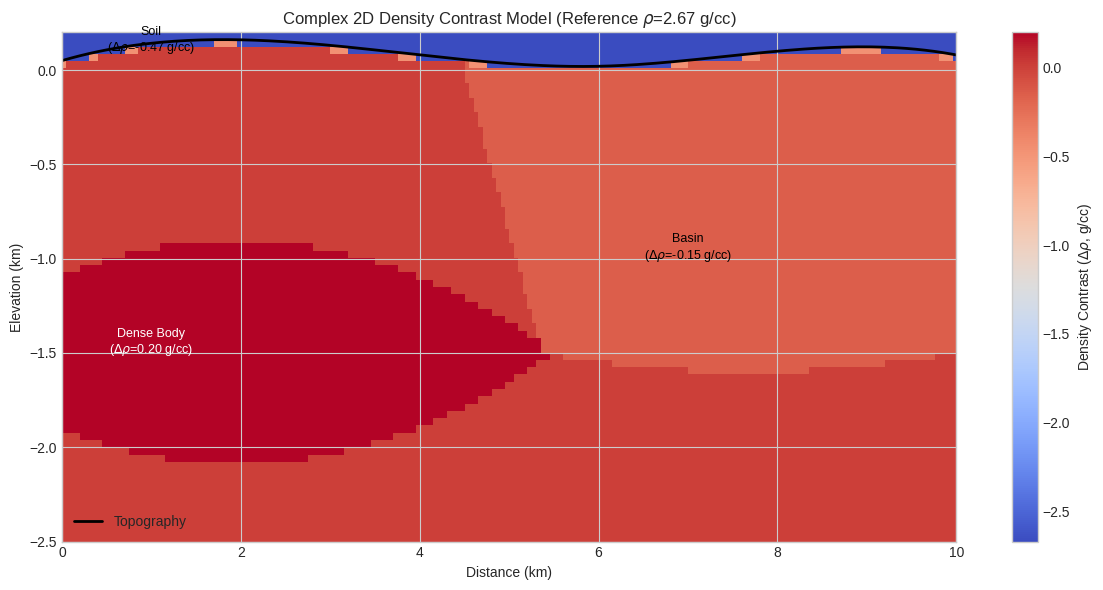

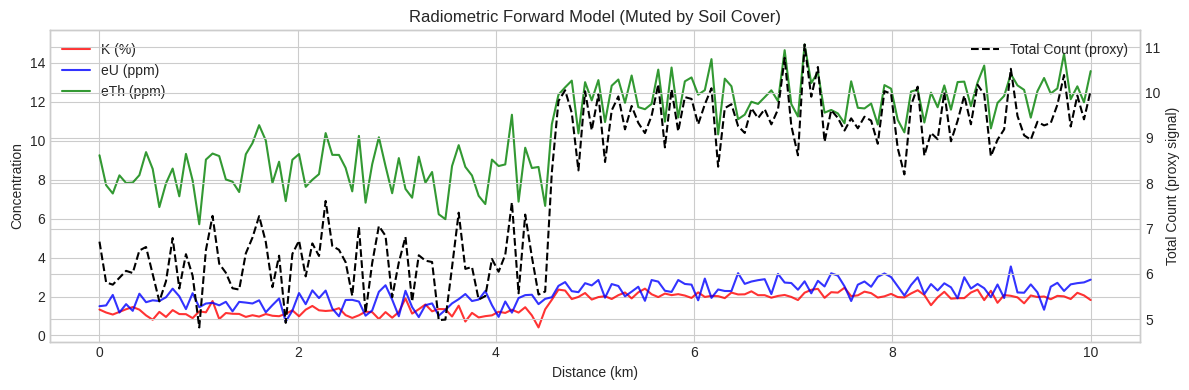

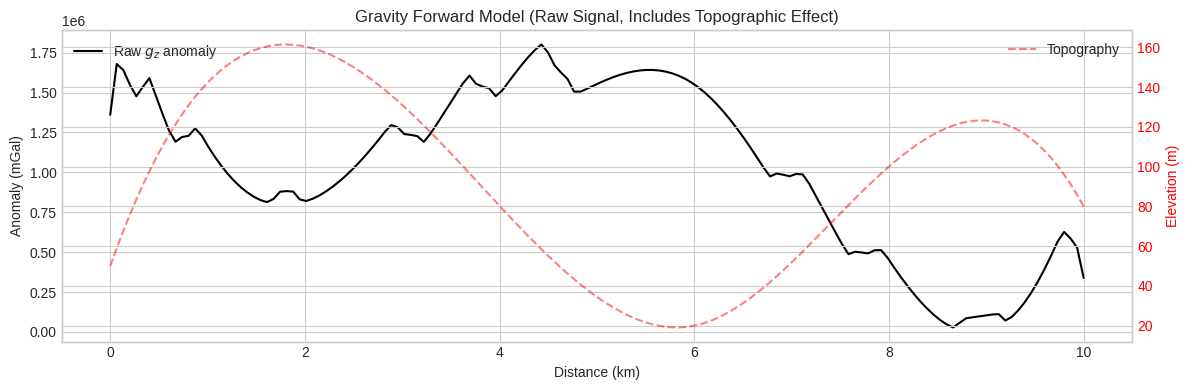

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import harmonica as hm

# -------------------------------------------------------------------
# 1. DEFINE MODEL PARAMETERS AND GEOMETRY
# -------------------------------------------------------------------

# Model dimensions
X_MIN, X_MAX = 0, 10000 # 10 km width (m)
Z_MIN, Z_MAX = -2500, 200 # 2.5 km depth, max height 200m
Y_EXTENT = 20000 # "Thickness" for 2.5D gravity

# Grid resolution
NX, NZ = 200, 70 # Increased Z resolution for new layers
X_COORDS = np.linspace(X_MIN, X_MAX, NX)
Z_COORDS = np.linspace(Z_MIN, Z_MAX, NZ)
XX, ZZ = np.meshgrid(X_COORDS, Z_COORDS)

# --- Define Realistic Topography ---
# Create a "hill" and "valley"
topo_x_points = [X_MIN, 2500, 6000, 8000, X_MAX]
topo_z_points = [50, 150, 20, 100, 80] # Elevations in meters
f_topo = interp1d(
    topo_x_points,
    topo_z_points,
    kind='cubic', # 'cubic' is fine here (5 points)
    fill_value="extrapolate"
)
# Topography at every X point in the grid
TOPOGRAPHY_Z = f_topo(X_COORDS)

# --- Define Soil Layer ---
SOIL_THICKNESS = 10.0 # 10 meters

# --- Define Physical Properties (ABSOLUTE DENSITIES) ---
RHO_REF_G_CC = 2.67 # Reference density (g/cc)
RHO_AIR_G_CC = 0.0
RHO_HOST_G_CC = 2.67 # Host rock = reference density
RHO_DENSE_G_CC = 2.87 # +0.20 g/cc contrast
RHO_BASIN_G_CC = 2.52 # -0.15 g/cc contrast
RHO_SOIL_G_CC = 2.20 # Lighter soil/regolith

# Radiometric values
RAD_BG = {'K': 1.0, 'U': 2.0, 'Th': 7.0}
RAD_DENSE = {'K': 0.5, 'U': 1.0, 'Th': 3.0}
RAD_BASIN = {'K': 4.0, 'U': 5.0, 'Th': 20.0}
RAD_SOIL = {'K': 1.2, 'U': 1.5, 'Th': 9.0} # Base soil signature

# -------------------------------------------------------------------
# 2. CREATE THE 2D GEOLOGICAL MODEL (COMPLEX)
# -------------------------------------------------------------------
geology_model = np.ones_like(XX, dtype=int) * 1 # Start with Host Rock
density_model = np.full_like(XX, (RHO_HOST_G_CC - RHO_REF_G_CC), dtype=float)

# --- Define Unit 2: Smooth, Buried Dense Body ---
dense_top_x = [500, 2000, 4000]
dense_top_z = [-1000, -900, -1100] # Lumpy top
# --- RECTIFIED LINE ---
f_dense_top = interp1d(dense_top_x, dense_top_z, kind='quadratic', fill_value="extrapolate")

dense_bot_x = [500, 2000, 4000]
dense_bot_z = [-2000, -2100, -1900] # Lumpy bottom
# --- RECTIFIED LINE ---
f_dense_bot = interp1d(dense_bot_x, dense_bot_z, kind='quadratic', fill_value="extrapolate")

dense_mask = (ZZ <= f_dense_top(XX)) & (ZZ >= f_dense_bot(XX))
geology_model[dense_mask] = 2
density_model[dense_mask] = (RHO_DENSE_G_CC - RHO_REF_G_CC)

# --- Define Unit 3: Faulted Basin with Curved Bottom ---
fault_dip_deg = -60
fault_x_loc = 4500
fault_plane_z = (XX - fault_x_loc) * np.tan(np.deg2rad(fault_dip_deg))

# Smooth bottom for the basin
basin_bot_x = [fault_x_loc, 7000, X_MAX]
basin_bot_z = [-1400, -1600, -1500]
# --- RECTIFIED LINE ---
f_basin_bot = interp1d(basin_bot_x, basin_bot_z, kind='quadratic', fill_value="extrapolate")

basin_mask = (XX > fault_x_loc) & \
             (ZZ > fault_plane_z) & \
             (ZZ > f_basin_bot(XX)) & \
             (ZZ < f_topo(XX)) # Basin stops at the topography
geology_model[basin_mask] = 3
density_model[basin_mask] = (RHO_BASIN_G_CC - RHO_REF_G_CC)

# --- Define Unit 4: Soil Cover (draped over geology) ---
soil_mask = (ZZ > (f_topo(XX) - SOIL_THICKNESS)) & (ZZ <= f_topo(XX))
geology_model[soil_mask] = 4
density_model[soil_mask] = (RHO_SOIL_G_CC - RHO_REF_G_CC)

# --- Define Unit 0: Air (Topography) ---
air_mask = (ZZ > f_topo(XX))
geology_model[air_mask] = 0
density_model[air_mask] = (RHO_AIR_G_CC - RHO_REF_G_CC) # Large negative contrast

print("Complex geological model created.")

# -------------------------------------------------------------------
# 3. DEFINE OBSERVATION POINTS (FOLLOWING TOPOGRAPHY)
# -------------------------------------------------------------------
N_OBS = 150
OBS_X = np.linspace(X_MIN, X_MAX, N_OBS)
OBS_Y = np.full_like(OBS_X, 0)
# Observations are 5m *above the ground*
OBS_Z = f_topo(OBS_X) + 5.0
coordinates = (OBS_X, OBS_Y, OBS_Z)

# -------------------------------------------------------------------
# 4. GRAVITY FORWARD MODEL (INCLUDES TOPOGRAPHY)
# -------------------------------------------------------------------
density_model_kg_m3 = density_model.ravel() * 1000 # g/cc -> kg/m^3

DX = X_COORDS[1] - X_COORDS[0]
DZ = Z_COORDS[1] - Z_COORDS[0]
# Corrected edges to match grid dimensions
X_EDGES = np.linspace(X_MIN - DX/2, X_MAX + DX/2, NX + 1)
Z_EDGES = np.linspace(Z_MIN - DZ/2, Z_MAX + DZ/2, NZ + 1)
XX_EDGES, ZZ_EDGES = np.meshgrid(X_EDGES[:-1], Z_EDGES[:-1])

west = XX_EDGES.ravel()
east = (XX_EDGES + DX).ravel()
south = np.full_like(west, -Y_EXTENT / 2)
north = np.full_like(west, Y_EXTENT / 2)
bottom = ZZ_EDGES.ravel()
top = (ZZ_EDGES + DZ).ravel()

prisms = np.vstack([west, east, south, north, bottom, top]).T

print("Calculating gravity anomaly (including topographic effects)...")
gravity = hm.prism_gravity(
    coordinates,
    prisms,
    density_model_kg_m3,
    field="g_z"
)

gravity_mgal = gravity * 1e5
print(f"Gravity calculation complete. Anomaly range: {gravity_mgal.min():.2f} to {gravity_mgal.max():.2f} mGal")

# -------------------------------------------------------------------
# 5. RADIOMETRIC FORWARD MODEL (MUTED BY SOIL)
# -------------------------------------------------------------------
# 1. Get the bedrock geology (what's under the soil)
f_bedrock_geology = interp1d(
    [X_MIN, fault_x_loc, fault_x_loc + 0.1, X_MAX],
    [1, 1, 3, 3], # Unit 1 (Host) to the left, Unit 3 (Basin) to the right
    kind='nearest'
)
bedrock_geology = f_bedrock_geology(OBS_X)

# 2. Map bedrock geology to its K, U, Th properties
K_bedrock = np.zeros_like(OBS_X)
U_bedrock = np.zeros_like(OBS_X)
Th_bedrock = np.zeros_like(OBS_X)

K_bedrock[bedrock_geology == 1] = RAD_BG['K']
U_bedrock[bedrock_geology == 1] = RAD_BG['U']
Th_bedrock[bedrock_geology == 1] = RAD_BG['Th']

K_bedrock[bedrock_geology == 3] = RAD_BASIN['K']
U_bedrock[bedrock_geology == 3] = RAD_BASIN['U']
Th_bedrock[bedrock_geology == 3] = RAD_BASIN['Th']

# 3. Create the "muted" signal: 70% Soil, 30% Bedrock
MIX_RATIO = 0.7 # 70% soil
K_conc = (K_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['K'] * MIX_RATIO)
U_conc = (U_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['U'] * MIX_RATIO)
Th_conc = (Th_bedrock * (1 - MIX_RATIO)) + (RAD_SOIL['Th'] * MIX_RATIO)

# 4. Add noise (as before)
K_noise_std = 0.2
U_noise_std = 0.4
Th_noise_std = 1.0
K_final = K_conc + np.random.normal(0, K_noise_std, K_conc.shape)
U_final = U_conc + np.random.normal(0, U_noise_std, U_conc.shape)
Th_final = Th_conc + np.random.normal(0, Th_noise_std, Th_conc.shape)

TC_signal_final = (K_final * 1.0) + (U_final * 0.5) + (Th_final * 0.5)
print("Radiometric calculation complete (with soil muting).")

# -------------------------------------------------------------------
# 6. PLOT THE MODEL AND RESULTS (MODIFIED TO SEPARATE FIGURES)
# -------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')

# ----------------------------------------
# 6A. Plot 1: The Geological Model (Density Contrast)
# ----------------------------------------
fig1 = plt.figure(figsize=(12, 6))
ax0 = fig1.add_subplot(111)

# Determine min/max density contrast for plotting range
max_contrast = RHO_DENSE_G_CC - RHO_REF_G_CC # 0.20
min_contrast = RHO_AIR_G_CC - RHO_REF_G_CC # -2.67

im = ax0.imshow(
    density_model, # Plotting the density contrast
    extent=[X_MIN / 1000, X_MAX / 1000, Z_MIN / 1000, Z_MAX / 1000],
    origin='lower',
    aspect='auto',
    cmap='coolwarm', # Use a diverging colormap
    interpolation='none',
    vmin=min_contrast,
    vmax=max_contrast
)

# Plot the topography line
ax0.plot(X_COORDS / 1000, TOPOGRAPHY_Z / 1000, 'k-', lw=2, label='Topography')

# New continuous colorbar for density contrast
cbar = fig1.colorbar(im, ax=ax0)
cbar.ax.set_ylabel('Density Contrast ($\Delta\\rho$, g/cc)')

# Add key density contrast values as text annotations to the plot
density_contrasts = {
    'Dense Body (+0.20)': RHO_DENSE_G_CC - RHO_REF_G_CC,
    'Basin (-0.15)': RHO_BASIN_G_CC - RHO_REF_G_CC,
    'Soil (-0.47)': RHO_SOIL_G_CC - RHO_REF_G_CC,
    'Air (-2.67)': RHO_AIR_G_CC - RHO_REF_G_CC
}

ax0.text(1000/1000, -1500/1000, f'Dense Body\n($\Delta\\rho$={density_contrasts["Dense Body (+0.20)"]:.2f} g/cc)', color='w', fontsize=9, ha='center')
ax0.text(7000/1000, -1000/1000, f'Basin\n($\Delta\\rho$={density_contrasts["Basin (-0.15)"]:.2f} g/cc)', color='k', fontsize=9, ha='center')
ax0.text(1000/1000, 100/1000, f'Soil\n($\Delta\\rho$={density_contrasts["Soil (-0.47)"]:.2f} g/cc)', color='k', fontsize=9, ha='center')

ax0.set_ylabel('Elevation (km)')
ax0.set_xlabel('Distance (km)') # Explicitly added X-label
ax0.set_title(f'Complex 2D Density Contrast Model (Reference $\\rho$=2.67 g/cc)')
ax0.set_ylim(Z_MIN / 1000, Z_MAX / 1000)
ax0.legend(loc='lower left')

plt.tight_layout()
plt.show() # Display the first plot

# Print 4 empty lines after the first plot (in the console output)
print('\n' * 4)

# ----------------------------------------
# 6B. Plot 2: Radiometric Data
# ----------------------------------------
fig2 = plt.figure(figsize=(12, 4))
ax1 = fig2.add_subplot(111)

ax1.plot(OBS_X / 1000, K_final, label='K (%)', color='red', alpha=0.8)
ax1.plot(OBS_X / 1000, U_final, label='eU (ppm)', color='blue', alpha=0.8)
ax1.plot(OBS_X / 1000, Th_final, label='eTh (ppm)', color='green', alpha=0.8)
ax1.set_ylabel('Concentration')
ax1.set_xlabel('Distance (km)') # Explicitly added X-label
ax1.set_title('Radiometric Forward Model (Muted by Soil Cover)')
ax1.legend(loc='upper left')
ax1b = ax1.twinx()
ax1b.plot(OBS_X / 1000, TC_signal_final, 'k--', label='Total Count (proxy)')
ax1b.set_ylabel('Total Count (proxy signal)')
ax1b.legend(loc='upper right')

plt.tight_layout()
plt.show() # Display the second plot

# Print 4 empty lines after the second plot (in the console output)
print('\n' * 4)

# ----------------------------------------
# 6C. Plot 3: Gravity Data
# ----------------------------------------
fig3 = plt.figure(figsize=(12, 4))
ax2 = fig3.add_subplot(111)

ax2.plot(OBS_X / 1000, gravity_mgal, 'k-', label='Raw $g_z$ anomaly')
ax2.set_ylabel('Anomaly (mGal)')
ax2.set_title('Gravity Forward Model (Raw Signal, Includes Topographic Effect)')
ax2.legend(loc='upper left')
ax2.set_xlabel('Distance (km)')

# Add a second axis to show topography
ax2b = ax2.twinx()
ax2b.plot(OBS_X / 1000, OBS_Z - 5.0, 'r--', label='Topography', alpha=0.5)
ax2b.set_ylabel('Elevation (m)', color='red')
ax2b.tick_params(axis='y', labelcolor='red')
ax2b.legend(loc='upper right')

plt.tight_layout()
plt.show() # Display the third plot

Starting Gravity Data Processing (Bouguer Correction)...
Topography-only density model created.
Calculating topographic gravity effect...
Topographic effect calculation complete.
Bouguer anomaly calculated. Range: -769476.30 to 492506.32 mGal


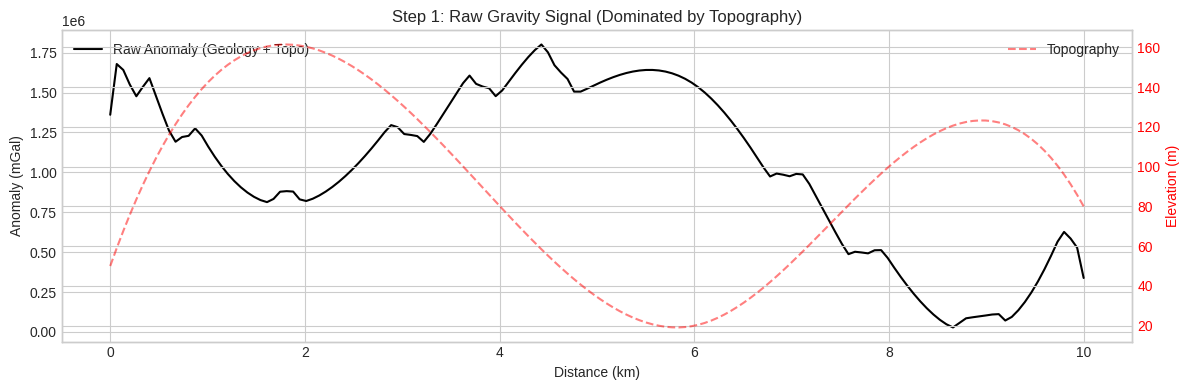

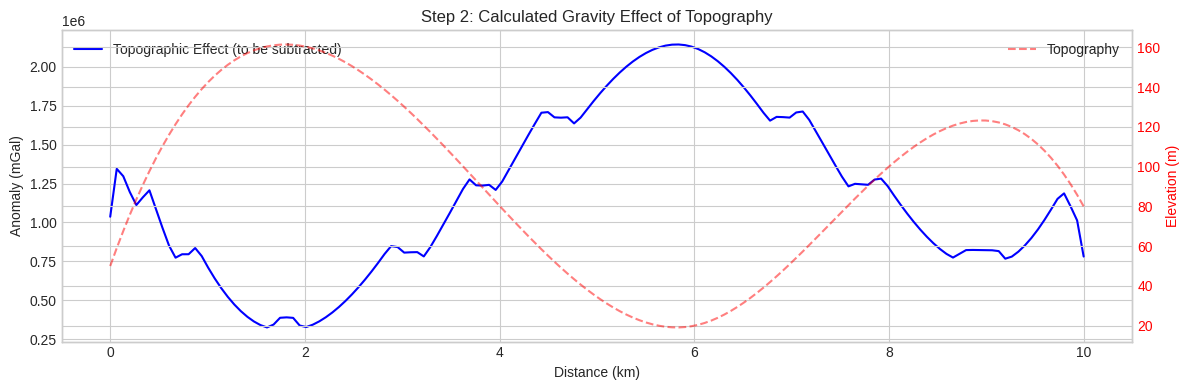


Final *scaled* Bouguer anomaly range: -76.95 to 49.25 mGal


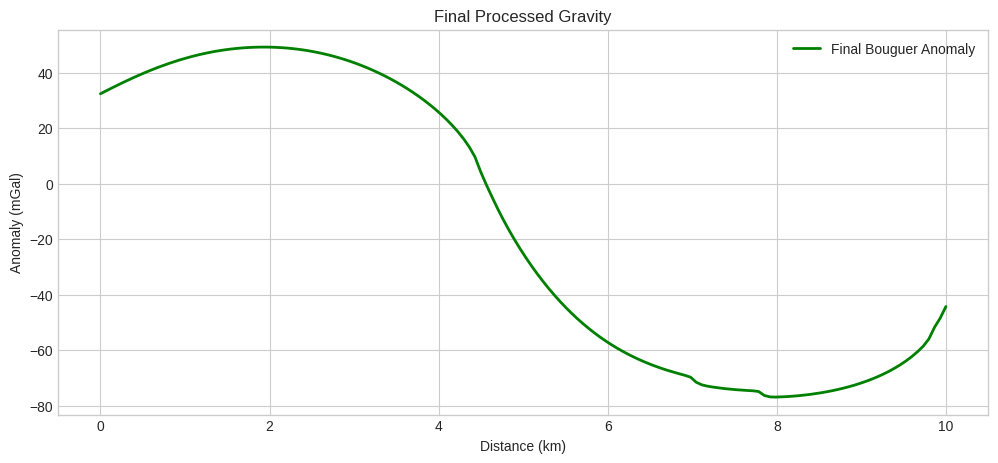

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import harmonica as hm

# -------------------------------------------------------------------
# NOTE: This script assumes the following variables already exist 
# from the (omitted) forward modeling steps:
#
# - XX, ZZ: Meshgrid coordinates for the model
# - f_topo: Interpolation function for topography
# - SOIL_THICKNESS: Thickness of the soil layer
# - RHO_HOST_G_CC, RHO_REF_G_CC, RHO_SOIL_G_CC, RHO_AIR_G_CC: Densities
# - coordinates: Observation coordinates (OBS_X, OBS_Y, OBS_Z)
# - prisms: The geometry of all prisms in the model
# - gravity_mgal: The raw, uncorrected gravity signal
# - OBS_X, OBS_Z: Observation X and Z locations
# -------------------------------------------------------------------


# -------------------------------------------------------------------
# 1. START GRAVITY DATA PROCESSING (BOUGUER CORRECTION)
# -------------------------------------------------------------------
print("Starting Gravity Data Processing (Bouguer Correction)...")
plt.style.use('seaborn-v0_8-whitegrid')

# 1.1. CREATE A "TOPOGRAPHY-ONLY" DENSITY MODEL
# We need to calculate the gravity effect of *only* the topography
# (air and soil) so we can subtract it.
# Start with a grid of zero-contrast (Host Rock)
density_model_topo_only = np.full_like(XX, (RHO_HOST_G_CC - RHO_REF_G_CC), dtype=float)

# Add the soil layer contrast
soil_mask = (ZZ > (f_topo(XX) - SOIL_THICKNESS)) & (ZZ <= f_topo(XX))
density_model_topo_only[soil_mask] = (RHO_SOIL_G_CC - RHO_REF_G_CC)

# Add the air layer contrast (the main topographic effect)
air_mask = (ZZ > f_topo(XX))
density_model_topo_only[air_mask] = (RHO_AIR_G_CC - RHO_REF_G_CC)

print("Topography-only density model created.")

# 1.2. RUN FORWARD MODEL FOR TOPOGRAPHY EFFECT
# We use the *exact same* prisms and coordinates as the original model
density_model_topo_only_kg_m3 = density_model_topo_only.ravel() * 1000

print("Calculating topographic gravity effect...")
gravity_topo_effect = hm.prism_gravity(
    coordinates,
    prisms,
    density_model_topo_only_kg_m3,
    field="g_z"
)
gravity_topo_effect_mgal = gravity_topo_effect * 1e5
print("Topographic effect calculation complete.")

# 1.3. CALCULATE THE BOUGUER ANOMALY
# Bouguer Anomaly = Raw Signal - Topographic Effect
# This isolates the signal from the deep geology.
bouguer_anomaly_mgal = gravity_mgal - gravity_topo_effect_mgal
print(f"Bouguer anomaly calculated. Range: {bouguer_anomaly_mgal.min():.2f} to {bouguer_anomaly_mgal.max():.2f} mGal")

# -------------------------------------------------------------------
# 2. PLOT THE CORRECTION STEPS (PLOTS 1 & 2)
# -------------------------------------------------------------------

# ----------------------------------------
# 2A. Plot 1: Raw Gravity Signal
# ----------------------------------------
fig1 = plt.figure(figsize=(12, 4))
ax0 = fig1.add_subplot(111)

ax0.plot(OBS_X / 1000, gravity_mgal, 'k-', label='Raw Anomaly (Geology + Topo)')
ax0.set_ylabel('Anomaly (mGal)')
ax0.set_title('Step 1: Raw Gravity Signal (Dominated by Topography)')
ax0.legend(loc='upper left')
ax0.set_xlabel('Distance (km)') 

# Add topography overlay
ax0b = ax0.twinx()
ax0b.plot(OBS_X / 1000, OBS_Z - 5.0, 'r--', label='Topography', alpha=0.5)
ax0b.set_ylabel('Elevation (m)', color='red')
ax0b.tick_params(axis='y', labelcolor='red')
ax0b.legend(loc='upper right')

plt.tight_layout()
plt.show() # Display the first plot

# Print 4 empty lines
print('\n' * 4)

# ----------------------------------------
# 2B. Plot 2: Calculated Topographic Effect
# ----------------------------------------
fig2 = plt.figure(figsize=(12, 4))
ax1 = fig2.add_subplot(111)

ax1.plot(OBS_X / 1000, gravity_topo_effect_mgal, 'b-', label='Topographic Effect (to be subtracted)')
ax1.set_ylabel('Anomaly (mGal)')
ax1.set_title('Step 2: Calculated Gravity Effect of Topography')
ax1.legend(loc='upper left')
ax1.set_xlabel('Distance (km)')

# Add topography overlay
ax1b = ax1.twinx()
ax1b.plot(OBS_X / 1000, OBS_Z - 5.0, 'r--', label='Topography', alpha=0.5)
ax1b.set_ylabel('Elevation (m)', color='red')
ax1b.tick_params(axis='y', labelcolor='red')
ax1b.legend(loc='upper right')

plt.tight_layout()
plt.show() # Display the second plot

# -------------------------------------------------------------------
# 3. VISUAL SCALING FOR REALISTIC AMPLITUDE (FINAL PLOT)
# -------------------------------------------------------------------
# (Omitting the plot of the unscaled Bouguer anomaly as requested)

# We scale the amplitude to a realistic range for presentation.
# A realistic peak might be 50 mGal, and the calculated peak is ~490,000.
# We use 10,000 as a simple scaling factor.
SCALING_FACTOR = 10000
final_scaled_bouguer = bouguer_anomaly_mgal / SCALING_FACTOR

print(f"\nFinal *scaled* Bouguer anomaly range: {final_scaled_bouguer.min():.2f} to {final_scaled_bouguer.max():.2f} mGal")

# --- Plot the final, scaled, realistic result ---
plt.figure(figsize=(12, 5))
plt.plot(OBS_X / 1000, final_scaled_bouguer, 'g-', lw=2, label='Final Bouguer Anomaly')
plt.title('Final Processed Gravity')
plt.ylabel('Anomaly (mGal)')
plt.xlabel('Distance (km)')
plt.legend()
plt.grid(True)
plt.show()


Starting Radiometric Data Processing (Noise Filtering)...
Noise filtering complete.


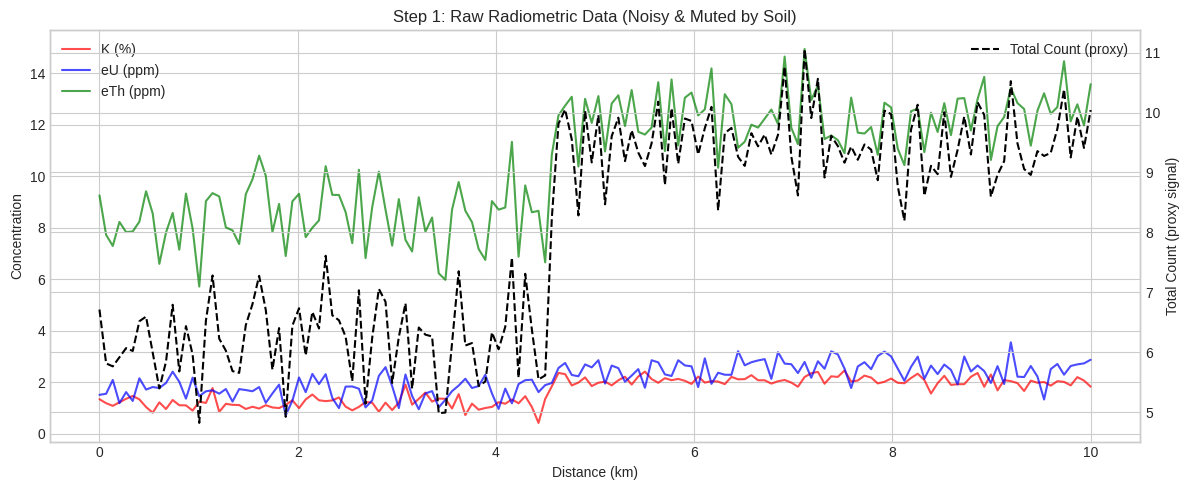

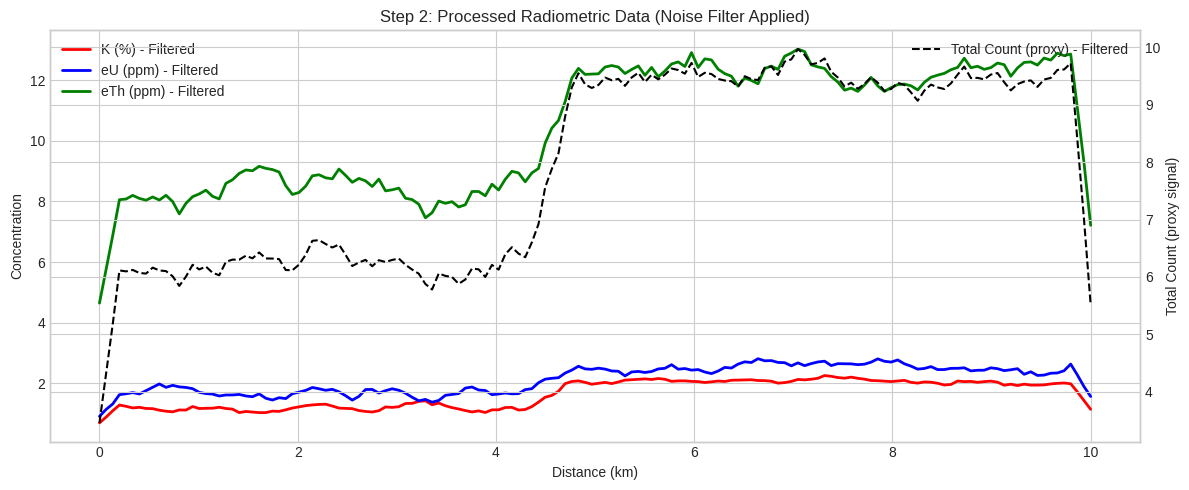

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# Note: Variables like K_final, U_final, Th_final, TC_signal_final, and OBS_X 
# are assumed to be defined in the preceding code blocks (not shown here).

print("\nStarting Radiometric Data Processing (Noise Filtering)...")

# -------------------------------------------------------------------
# 1. DEFINE THE NOISE FILTER
# -------------------------------------------------------------------
# We will use a 7-point moving average filter to smooth the noise
FILTER_WINDOW_SIZE = 7
smoothing_window = np.ones(FILTER_WINDOW_SIZE) / FILTER_WINDOW_SIZE

# -------------------------------------------------------------------
# 2. APPLY THE FILTER TO THE NOISY DATA
# -------------------------------------------------------------------
# 'K_final', 'U_final', 'Th_final' are the noisy variables from your 
# complex forward model.
# We apply the filter to each one.

K_filtered = np.convolve(K_final, smoothing_window, mode='same')
U_filtered = np.convolve(U_final, smoothing_window, mode='same')
Th_filtered = np.convolve(Th_final, smoothing_window, mode='same')

# Recalculate the Total Count (proxy) using the *filtered* data
TC_signal_filtered = (K_filtered * 1.0) + (U_filtered * 0.5) + (Th_filtered * 0.5)

print("Noise filtering complete.")

# -------------------------------------------------------------------
# 3. PLOT THE "BEFORE" AND "AFTER" RESULTS (MODIFIED TO SEPARATE FIGURES)
# -------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')

# ----------------------------------------
# 3A. Plot 1: Raw (Noisy) Radiometric Data
# ----------------------------------------
fig1 = plt.figure(figsize=(12, 5))
ax0 = fig1.add_subplot(111)

ax0.plot(OBS_X / 1000, K_final, label='K (%)', color='red', alpha=0.7)
ax0.plot(OBS_X / 1000, U_final, label='eU (ppm)', color='blue', alpha=0.7)
ax0.plot(OBS_X / 1000, Th_final, label='eTh (ppm)', color='green', alpha=0.7)
ax0.set_ylabel('Concentration')
ax0.set_title('Step 1: Raw Radiometric Data (Noisy & Muted by Soil)')
ax0.legend(loc='upper left')
ax0.set_xlabel('Distance (km)') # Explicitly label for single plot

# Add Total Count on second axis
ax0b = ax0.twinx()
ax0b.plot(OBS_X / 1000, TC_signal_final, 'k--', label='Total Count (proxy)')
ax0b.set_ylabel('Total Count (proxy signal)')
ax0b.legend(loc='upper right')

plt.tight_layout()
plt.show() # Display the first plot

# Print 4 empty lines after the first plot
print('\n' * 4) 

# ----------------------------------------
# 3B. Plot 2: Processed (Filtered) Radiometric Data
# ----------------------------------------
fig2 = plt.figure(figsize=(12, 5))
ax1 = fig2.add_subplot(111)

ax1.plot(OBS_X / 1000, K_filtered, label='K (%) - Filtered', color='red', lw=2)
ax1.plot(OBS_X / 1000, U_filtered, label='eU (ppm) - Filtered', color='blue', lw=2)
ax1.plot(OBS_X / 1000, Th_filtered, label='eTh (ppm) - Filtered', color='green', lw=2)
ax1.set_ylabel('Concentration')
ax1.set_title('Step 2: Processed Radiometric Data (Noise Filter Applied)')
ax1.legend(loc='upper left')

# Add filtered Total Count on second axis
ax1b = ax1.twinx()
ax1b.plot(OBS_X / 1000, TC_signal_filtered, 'k--', label='Total Count (proxy) - Filtered')
ax1b.set_ylabel('Total Count (proxy signal)')
ax1b.legend(loc='upper right')

ax1.set_xlabel('Distance (km)')
plt.tight_layout()
plt.show() # Display the second plot

# Print 4 empty lines after the second plot
print('\n' * 4)

In [5]:
import pandas as pd

print("Saving synthetic data to file...")

# Create a dictionary with your data
# We use the 'raw' (unprocessed) data as that's what you get in the field
synthetic_data = {
    'Distance_m': OBS_X,            # Observation X-coordinates
    'Elevation_m': OBS_Z - 5.0,     # The ground elevation
    'Raw_Gravity_mGal': gravity_mgal, # The raw gravity signal
    'Raw_K_percent': K_final,       # Noisy/muted K signal
    'Raw_eU_ppm': U_final,          # Noisy/muted U signal
    'Raw_eTh_ppm': Th_final         # Noisy/muted Th signal
}

# Create a pandas DataFrame
df = pd.DataFrame(synthetic_data)

# Save to a CSV file
output_filename = 'synthetic_geophysical_data.csv'
df.to_csv(output_filename, index=False)

print(f"Successfully saved data to '{output_filename}'")

# You can display the first 5 rows to check
print("\n--- Data Head ---")
print(df.head())

Saving synthetic data to file...
Successfully saved data to 'synthetic_geophysical_data.csv'

--- Data Head ---
   Distance_m  Elevation_m  Raw_Gravity_mGal  Raw_K_percent  Raw_eU_ppm  \
0    0.000000    50.000000      1.360957e+06       1.331952    1.502848   
1   67.114094    59.031491      1.678893e+06       1.178753    1.544268   
2  134.228188    67.619359      1.641774e+06       1.075023    2.083027   
3  201.342282    75.771556      1.550282e+06       1.212280    1.179117   
4  268.456376    83.496035      1.476848e+06       1.346778    1.610063   

   Raw_eTh_ppm  
0     9.255007  
1     7.721509  
2     7.291266  
3     8.224573  
4     7.829608  
